Wrote 220 bytes.
Wrote 243 bytes.
Wrote 127 bytes.


driver_id,driver_name,city,experience_years,rating
1,Arun Kumar,Bangalore,4,4.6
2,Pooja Rao,Chennai,2,4.3
3,Imran Sheikh,Delhi,6,4.8
4,Nisha Patel,Hyderabad,1,4.0
5,Rajesh Naik,Mumbai,8,4.9
6,Sneha Menon,Bangalore,3,4.4


ride_id,driver_id,distance_km,price,ride_date
1001,1,10,250,2024-02-01
1002,2,7,180,2024-02-03
1003,3,15,500,2024-02-05
1004,4,5,120,2024-02-08
1005,1,12,300,2024-02-10
1006,5,20,800,2024-02-15
1007,6,9,230,2024-02-20
1008,7,11,270,2024-02-22


ride_id,customer_feedback
1001,Excellent
1002,Good
1003,Excellent
1004,Average
1005,Good
1006,Excellent
1007,Average
1008,Good


root
 |-- driver_id: integer (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- experience_years: integer (nullable = true)
 |-- rating: double (nullable = true)

root
 |-- ride_id: integer (nullable = true)
 |-- driver_id: integer (nullable = true)
 |-- distance_km: integer (nullable = true)
 |-- price: integer (nullable = true)
 |-- ride_date: date (nullable = true)

root
 |-- ride_id: integer (nullable = true)
 |-- customer_feedback: string (nullable = true)

+---------+-------+-----------+-----+----------+
|driver_id|ride_id|distance_km|price| ride_date|
+---------+-------+-----------+-----+----------+
|        7|   1008|         11|  270|2024-02-22|
+---------+-------+-----------+-----+----------+



city,total_revenue
null,270
Bangalore,780
Chennai,180
Delhi,500
Mumbai,800
Hyderabad,120


+---------+----------+
|     city|avg_rating|
+---------+----------+
|Bangalore|       4.5|
|  Chennai|       4.3|
|    Delhi|       4.8|
|   Mumbai|       4.9|
|Hyderabad|       4.0|
+---------+----------+

+------------+---------+-----+
| driver_name|     city|price|
+------------+---------+-----+
|        NULL|     NULL|  270|
|  Arun Kumar|Bangalore|  300|
|   Pooja Rao|  Chennai|  180|
|Imran Sheikh|    Delhi|  500|
| Nisha Patel|Hyderabad|  120|
| Rajesh Naik|   Mumbai|  800|
+------------+---------+-----+

+---------+-----------+----+----------------+------+
|driver_id|driver_name|city|experience_years|rating|
+---------+-----------+----+----------------+------+
+---------+-----------+----+----------------+------+

+-------+---------+-----------+-----+----------+------------+---------+----------------+------+------------------+-----------------+
|ride_id|driver_id|distance_km|price| ride_date| driver_name|     city|experience_years|rating|   earnings_per_km|customer_feedback|
+-

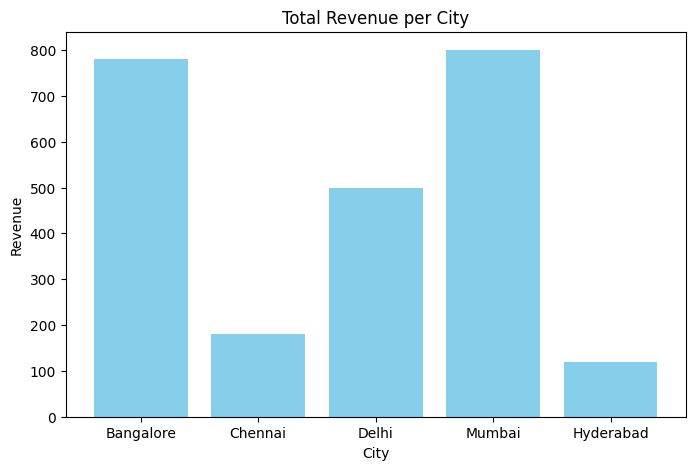

In [0]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, avg, count, row_number
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

# Create Spark session (Databricks auto-provides spark)
spark = SparkSession.builder.appName("RideShareAnalytics").getOrCreate()

# Create CSV files directly in DBFS

csv_drivers = """driver_id,driver_name,city,experience_years,rating
1,Arun Kumar,Bangalore,4,4.6
2,Pooja Rao,Chennai,2,4.3
3,Imran Sheikh,Delhi,6,4.8
4,Nisha Patel,Hyderabad,1,4.0
5,Rajesh Naik,Mumbai,8,4.9
6,Sneha Menon,Bangalore,3,4.4
"""

csv_rides = """ride_id,driver_id,distance_km,price,ride_date
1001,1,10,250,2024-02-01
1002,2,7,180,2024-02-03
1003,3,15,500,2024-02-05
1004,4,5,120,2024-02-08
1005,1,12,300,2024-02-10
1006,5,20,800,2024-02-15
1007,6,9,230,2024-02-20
1008,7,11,270,2024-02-22
"""

csv_feedback = """ride_id,customer_feedback
1001,Excellent
1002,Good
1003,Excellent
1004,Average
1005,Good
1006,Excellent
1007,Average
1008,Good
"""

# Write CSV data to DBFS (FileStore)
dbutils.fs.put("/FileStore/tables/drivers.csv", csv_drivers, True)
dbutils.fs.put("/FileStore/tables/rides.csv", csv_rides, True)
dbutils.fs.put("/FileStore/tables/feedback.csv", csv_feedback, True)

# Read CSV files into DataFrames

drivers_df = spark.read.csv("/FileStore/tables/drivers.csv", header=True, inferSchema=True)
rides_df = spark.read.csv("/FileStore/tables/rides.csv", header=True, inferSchema=True)
feedback_df = spark.read.csv("/FileStore/tables/feedback.csv", header=True, inferSchema=True)

# Display DataFrames
display(drivers_df)
display(rides_df)
display(feedback_df)

# Print schemas
drivers_df.printSchema()
rides_df.printSchema()
feedback_df.printSchema()

# Identify rides with missing drivers
rides_missing_drivers = rides_df.join(drivers_df, "driver_id", "left_anti")
rides_missing_drivers.show()

# Join rides and drivers to include city, experience_years, rating
rides_drivers_df = rides_df.join(drivers_df, "driver_id", "left")

# Add earnings_per_km column
rides_drivers_df = rides_drivers_df.withColumn("earnings_per_km", col("price") / col("distance_km"))

# Calculate total revenue per city
revenue_per_city = rides_drivers_df.groupBy("city").agg(_sum("price").alias("total_revenue"))
display(revenue_per_city)

# Determine average rating by city
avg_rating_city = drivers_df.groupBy("city").agg(avg("rating").alias("avg_rating"))
avg_rating_city.show()

# Find the top earning driver in each city using window function
windowSpec = Window.partitionBy("city").orderBy(col("price").desc())
top_driver_city = rides_drivers_df.withColumn("rank", row_number().over(windowSpec)).filter(col("rank") == 1)
top_driver_city.select("driver_name", "city", "price").show()

# Identify drivers with no rides (Left Join)
drivers_no_rides = drivers_df.join(rides_df, "driver_id", "left_anti")
drivers_no_rides.show()

# Combine feedback dataset to mark ride performance
rides_feedback_df = rides_drivers_df.join(feedback_df, "ride_id", "left")
rides_feedback_df.show()

# Count rides by feedback category (Excellent/Good/Average)
feedback_count = rides_feedback_df.groupBy("customer_feedback").agg(count("*").alias("ride_count"))
feedback_count.show()

# Using SQL view, find cities with highest average ride price
rides_feedback_df.createOrReplaceTempView("rides_summary")
spark.sql("""
    SELECT city, AVG(price) AS avg_price
    FROM rides_summary
    GROUP BY city
    ORDER BY avg_price DESC
""").show()

# Save final combined DataFrame to DBFS
rides_feedback_df.write.mode("overwrite").csv("/FileStore/tables/rides_summary.csv")

# Plot total revenue per city as a bar chart
pdf_revenue = revenue_per_city.toPandas()
pdf_revenue = pdf_revenue[pdf_revenue['city'].notnull()]

plt.figure(figsize=(8,5))
plt.bar(pdf_revenue['city'], pdf_revenue['total_revenue'], color='skyblue')
plt.title('Total Revenue per City')
plt.xlabel('City')
plt.ylabel('Revenue')
plt.show()
